<a href="https://colab.research.google.com/github/DanielP520/MAGPIE/blob/main/MAGPIE_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/glasgowlab/MAGPIE/blob/GoogleColab/magpie_logo.png?raw=1" alt= “magpie_logo” width="100" align="right">

## **MAGPIE: an interactive tool for visualizing and analyzing many simultaneous protein interactions with a binding partner**

**What is this tool?**

MAGPIE is an online tool hosted on Google Colab that generates 3D visualizations for sets of protein binders interacting with one target ligand (which can be a protein or a small molecule). It also produces sequence logo-style amino acid (AA) frequency graphs. In the AA frequency graphs, the user chooses target ligand positions on the fly, and the size of each binder AA is based on the frequency that it appears in the protein complex dataset within a user-defined distance from the chosen target ligand position(s). The distance is calculated using the alpha carbon positions between protein interfaces, or all heavy atoms in the case of ligands. MAGPIE's 3D visualizer plots the entire target structure, and highlights the residues within a specified distance constraint. There are two options for coloring the interacting residues based on [Amino colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#aminocolours) and [Shapely colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#shapelycolours). If you prefer to keep the data private, or have >1000 input PDB files, it is better to clone the [local version](https://github.com/glasgowlab/MAGPIE/tree/local-version).

**Required inputs:**
- PDB files: these should be aligned on the target ligands. Two examples are provided on GitHub, one for protein-protein interactions and one for small molecule-protein interactions.
- Target chain ID from PDB: the program uses the first file in the directory to upload the target ligand structure.
- Protein binder chain ID from PDB: this chain identifier must be the same across all PDB files.
- Target type: indicate whether the target ligand is a small molecule or a protein.
- Target residue index (for protein ligands) or unique atom names (for small molecule ligands): provide the target residue indices for proteins or unique atom names for small molecules. Alternatively, you can input 'all' to consider all AAs/heavy atoms.

**Usage:**
Please execute the cells in numerical order. If you wish to load a different dataset, start from the upload step to reload the new data.


In [1]:
#@title ##1. Install and import required packages.
%%capture

from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/glasgowlab/MAGPIE.git
%cd MAGPIE
!pip install logomaker
!pip install rarfile
!pip install biopython

import pandas as pd
import helper_functions
import sequence_logo_main
import os
import glob
import zipfile
import tarfile
import rarfile
%matplotlib notebook
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
try:
  os.mkdir('temp')
except:
  print("Done")



In [7]:
#@title ##2. Upload and process data.
# @markdown Navigate to the File menu located top left of the screen. Upload data into the **temp** directory, in the form of a compressed directory in .zip format containing the PDB input files. It is also possible to directly upload the PDB files into the temp folder, but this might take a long time depending on the number of files.
# @markdown
# @markdown   There are two example datasets to test MAGPIE: a small molecule-protein example and a protein-protein example.
# @markdown
# @markdown    Select which dataset you would like to use:
import zipfile


def extract_file(archive_path, output_folder):
    if zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)
    else:
        print(f"{archive_path} is not a zip file")

uploaded_data_set = False #@param {type:"boolean"}
protein_protein_example_data = True  #@param {type:"boolean"}
protein_ligand_example_data = False  #@param {type:"boolean"}
if uploaded_data_set:
  zip_files = glob.glob("temp/" +"*.zip")
  files = zip_files
  pdb_files =[]
  for zip in files:
      extract_file(zip, "temp")
      zip = zip.split(".zip")[0]
      pdb_files +=  glob.glob(zip + "/*.pdb")

elif protein_ligand_example_data:
  pdb_files = glob.glob("Ligand Example/" + "*.pdb")
elif protein_protein_example_data:
    pdb_files = glob.glob("Protein Example/" + "*.pdb")

print(pdb_files)

['Protein Example/P2C-1F11_7CDI_cleaned.pdb', 'Protein Example/H014_7CAI_cleaned.pdb', 'Protein Example/P17_7CWN_cleaned.pdb', 'Protein Example/H11-H4_6ZH9_cleaned.pdb', 'Protein Example/COVA2-04_7JMO_cleaned.pdb', 'Protein Example/Ty1_6ZXN_cleaned.pdb', 'Protein Example/S2E12_7K4N_cleaned.pdb', 'Protein Example/C121_7K8X_cleaned.pdb', 'Protein Example/LY-CoV555_7KMG_cleaned.pdb', 'Protein Example/SR4_7C8V_cleaned.pdb', 'Protein Example/2H2_7DK4_cleaned.pdb', 'Protein Example/mNb6_7KKL_cleaned.pdb', 'Protein Example/C1A-B12_7KFV_cleaned.pdb', 'Protein Example/S2M11_7K43_cleaned.pdb', 'Protein Example/LY-CoV481_7KMI_cleaned.pdb', 'Protein Example/EY6A_6ZCZ_cleaned.pdb', 'Protein Example/MR17_7C8W_cleaned.pdb', 'Protein Example/P2C-1A3_7CDJ_cleaned.pdb', 'Protein Example/REGN10933_6XDG_cleaned.pdb', 'Protein Example/C119_7K8W_cleaned.pdb', 'Protein Example/S2H14_7JX3_cleaned.pdb', 'Protein Example/S2A4_7JVC_cleaned.pdb', 'Protein Example/Nb20_7JVB_cleaned.pdb', 'Protein Example/LY-CoV488

In [3]:
#@title ##3. Select target ligand and protein binder chains.

# @markdown Select target ligand and protein binder chains, decide whether the target ligand is a ligand or protein, provide heavy atom names (if small molecule ligand) or residue index (if protein ligand) to plot around, and provide the distance in Ångstroms to graph from the target chain.

#@markdown You can also type 'all' to plot all residues or atoms.

# @markdown For the protein target example, use A for the target ligand chain and C for the protein binder chain.

# @markdown For the small molecule target example, use X for the target chain and A for the protein binder chain. Check the is_ligand option.

target_chain = "A"#@param {type:"string"}
binding_chain = "C"#@param {type:"string"}
download_meta = True #@param {type:"boolean"}

is_ligand = False #@param {type:"boolean"}
distance = '8' #@param {type:"string"}
distance = int(distance)

eps = 2
min_samples = 15


# @markdown MAGPIE uses DBSCAN to cluster points in 3d without requiring to specify the number of desired clusters.

# @markdown Run the folliwng cell if you are interested in changing:

# @markdown eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.

# @markdown min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.


# @markdown Default is eps = 2.0, min_samples = 15

eps = '2' #@param {type:"string"}
min_samples = '15' #@param {type:"string"}

eps = float(eps)
min_samples = int(15)

In [10]:
#@title #4. Plot points in 3D viewer.
# @markdown This might take a couple of minutes depending on the size of the dataset. It takes around one minute for the protein-protein example.
from matplotlib.pyplot import plot
configure_plotly_browser_state()
df_target,df_binder,return_from_clusters = sequence_logo_main.plot(pdb_files, target_chain,binding_chain,is_ligand, distance, download_meta,[eps,min_samples])
sequence_logo_main.plot_cluster_compositions(return_from_clusters)


<IPython.core.display.Javascript object>

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:


#@title #5. Select target ligand residues or heavy atoms to generate AA frequency graphs.
# @markdown Enter the target residue indices or heavy atom names to graph. These should be separated by commas, without spaces (e.g., N1A,N3A,N9A).
# @markdown
# @markdown If there are no residues within the given range, the next cell will not execute.
sequence_logo_targets = "CDP"#@param {type:"string"}

if is_ligand:
  plot_list = [str(x) for x in sequence_logo_targets.split(",")]
else:
  plot_list =[int(x) for x in sequence_logo_targets.split(",")]



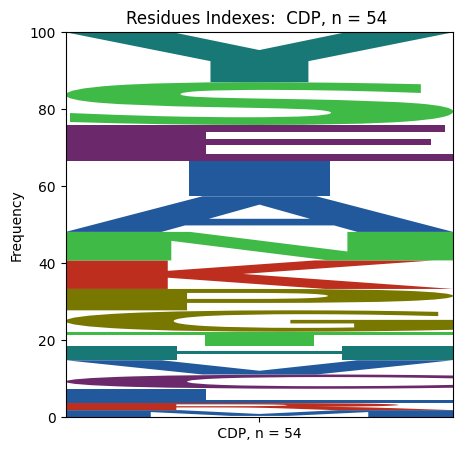

In [ ]:
#@title #6.  Generate AA frequency graphs.
# @markdown Select if you'd like to only see the combined AA frequency graph.

combined = True #@param {type:"boolean" }
%matplotlib inline
sequence_logo_main.sequence_logos(df_target,df_binder, plot_list, is_ligand,combined, distance)